## Current baseline:

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt

In [3]:
from problem import get_train_data, get_test_data, WeightedClassificationError

In [4]:
pip install tensorflow #pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#pickle'


In [5]:
import numpy as np
import tensorflow as tf
from time import time
import pandas as pd
import math

In [6]:
videos_train, labels_train = get_train_data()

In [7]:
len(videos_train)

177

In [8]:
#Filtering only class A and class H
def filter(filters,x,y):
    rx=x.copy()
    ry=y.copy()
    ry=list(ry)
    
    df = pd.DataFrame({'labels':ry,'features':rx})
    df = df[~df.labels.isin(filters)]
    ry = df['labels'].tolist()
    rx = df['features'].tolist()
    
    return rx,ry

In [9]:
filters= ['B','C','D','E','F','G']
a,b=filter(filters,videos_train, labels_train)
#videos_train= a
#labels_train= np.array(b)

In [10]:
#transforming the data set: each observation now correponds the nth observation
def nth_frame(videolist, n):
    n = 300
    nth_frames=[]
    i=0
    for video in videolist:
        i+=1
        time= video.frame_times[n-1]
        frame= video.read_frame(time)
        nth_frames.append(frame)
    return nth_frames

In [11]:
def create_dataset(startFrame, endFrame, x, y):
    print("for n= ",startFrame)
    xres= nth_frame(x,startFrame)
    yres= np.array(y)
    print("x:",len(xres))
    print("y:",len(yres))
    for i in range(startFrame+1, endFrame+1):
        print("for n= ",i)
        temp= nth_frame(x,i)
        xres+= temp
        print("x:",len(xres))
        yres= np.append(yres,np.array(y))
        print("y:",len(yres))
    return xres,yres

In [12]:
builtx, builty= create_dataset(290,300, videos_train, labels_train)

for n=  290
x: 177
y: 177
for n=  291
x: 354
y: 354
for n=  292
x: 531
y: 531
for n=  293
x: 708
y: 708
for n=  294
x: 885
y: 885
for n=  295
x: 1062
y: 1062
for n=  296
x: 1239
y: 1239
for n=  297
x: 1416
y: 1416
for n=  298
x: 1593
y: 1593
for n=  299
x: 1770
y: 1770
for n=  300
x: 1947
y: 1947


In [13]:
X_for_classifier= np.array(builtx)
y_for_classifier= builty

In [20]:
X_for_classifier[None, ...].shape

(1, 1947, 250, 250, 3)

In [15]:
#temp fix to make it work with MobileNetV2

grayscale_batch=X_for_classifier
rgb_batch = np.repeat(grayscale_batch[...,np.newaxis], 3, -1)


In [16]:
X_for_classifier= rgb_batch

In [17]:
X_for_classifier.shape

(1947, 250, 250, 3)

In [16]:
#test after transformation: prints all images of dataset
#for i in range(0,176):
#    plt.imshow(X_for_classifier[i], cmap='gray')
#    title_obj = plt.title(y_for_classifier[i]) 
#    plt.axis('off')
#    plt.show()


In [17]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':1,
        'C':2,
        'D':3,
        'E':4,
        'F':5,
        'G':6,
        'H':7,
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")
 

In [18]:
func=np.vectorize(class_to_int)
y_for_classifier=func(y_for_classifier)

In [19]:
y_for_classifier

array([7, 7, 0, ..., 7, 3, 3])

In [20]:

#import numpy as np


#class VideoClassifier(object):
#    def __init__(self):
#        pass

#    def fit(self, videos: list, y, pred_time: float):
#        classes = ["A", "B", "C", "D", "E", "F", "G", "H"]
#        self.n_classes = len(classes)
#        print(type(self))
#        pass

#    def predict(self, videos: list, pred_time: float):
#        proba = np.random.rand(len(videos), self.n_classes)
#        proba /= proba.sum(axis=1)[:, np.newaxis]
#        return proba



## Data Augmentation with Keras ImageDataGenerator

In [21]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, 
        rotation_range=30, fill_mode='nearest',
        width_shift_range=0.1, height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8,1.2] #above 1 light , below darkens
)

In [22]:
XY_classifier_augmented= datagen.flow(X_for_classifier, y_for_classifier, batch_size=32)

In [23]:
#(next(XY_classifier_augmented))[1]

(-0.5, 249.5, 249.5, -0.5)

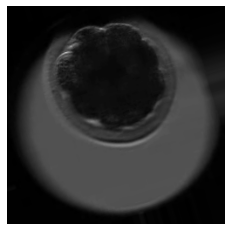

In [24]:
batch= next(XY_classifier_augmented)[0]
image=batch[30]
plt.imshow(image)
plt.axis('off')

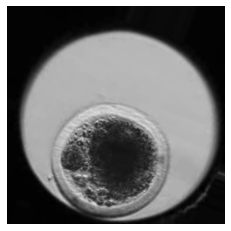

In [25]:
#fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

#for i in :

    # convert to unsigned integers
batch = next(XY_classifier_augmented)[0]
 
    # plot image
    #ax[i].
for image in batch:
    plt.imshow(image)
    plt.axis('off')

## new Baseline test

### predefined pred times:

 ensuring that only frames up to pred_times are used for model training and testing. None is the whole 300 frames.

In [26]:
pred_times = [27, 32, 37, 40, 44, 48, 53, 58, 63, 94, None]

### Build the model

In [27]:
# Image shape for classifier
IMG_SHAPE = (250,250,3)

# Building of a classification model
base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
    )
base_model.trainable = False
inputs = tf.keras.Input(shape=IMG_SHAPE)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(8, activation="softmax")
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["sparse_categorical_accuracy"],
)

model.summary()


2022-05-13 16:42:32.247338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [28]:
# Uncomment this line to fit the classifier

#model.fit(XY_classifier_augmented, epochs=100)

model.fit(X_for_classifier,y_for_classifier, epochs=100)

Epoch 1/100
61/61 [==============================] - 52s 804ms/step - loss: 2.2212 - sparse_categorical_accuracy: 0.2008
Epoch 2/100
61/61 [==============================] - 46s 756ms/step - loss: 2.0189 - sparse_categorical_accuracy: 0.2686
Epoch 3/100
61/61 [==============================] - 46s 754ms/step - loss: 1.9100 - sparse_categorical_accuracy: 0.2907
Epoch 4/100
61/61 [==============================] - 46s 756ms/step - loss: 1.7893 - sparse_categorical_accuracy: 0.3529
Epoch 5/100
61/61 [==============================] - 46s 759ms/step - loss: 1.7086 - sparse_categorical_accuracy: 0.3616
Epoch 6/100
61/61 [==============================] - 46s 754ms/step - loss: 1.6064 - sparse_categorical_accuracy: 0.4160
Epoch 7/100
61/61 [==============================] - 46s 756ms/step - loss: 1.5500 - sparse_categorical_accuracy: 0.4432
Epoch 8/100
61/61 [==============================] - 46s 756ms/step - loss: 1.4695 - sparse_categorical_accuracy: 0.4771
Epoch 9/100
61/61 [=============

In [29]:
# Uncomment this cell to Load a previously saved model
#MODEL_NAME_FOR_PREDICTION = "classifier3"
#model = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, MODEL_NAME_FOR_PREDICTION))

In [30]:
def predict_image(image, model):
    image = Image.fromarray(image)
    image = image.resize((250,250))
    image = np.array(image)
    image = tf.reshape(image, (1,250,250))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)

### Loading test data

In [47]:
videos_test, labels_test  = get_test_data()

In [32]:
#videos_test, labels_test=filter(filters,videos_test, labels_test)



In [48]:
builtx, builty= create_dataset(290,300, videos_test, labels_test)

for n=  290
x: 100
y: 100
for n=  291
x: 200
y: 200
for n=  292
x: 300
y: 300
for n=  293
x: 400
y: 400
for n=  294
x: 500
y: 500
for n=  295
x: 600
y: 600
for n=  296
x: 700
y: 700
for n=  297
x: 800
y: 800
for n=  298
x: 900
y: 900
for n=  299
x: 1000
y: 1000
for n=  300
x: 1100
y: 1100


In [49]:
Xtest_for_classifier = np.array(builtx)
ytest_for_classifier = np.array(builty)

In [50]:
ytest_for_classifier

array(['A', 'A', 'G', ..., 'E', 'D', 'D'], dtype=object)

In [51]:
grayscale_batch=Xtest_for_classifier
rgb_batch = np.repeat(grayscale_batch[..., np.newaxis], 3, -1)

In [52]:
ytest_for_classifier=func(ytest_for_classifier)

In [53]:
ytest_for_classifier

array([0, 0, 6, ..., 4, 3, 3])

In [54]:
Xtest_for_classifier= rgb_batch

In [55]:
Xtest_for_classifier.shape

(1100, 250, 250, 3)

In [56]:
loss, accuracy = model.evaluate(Xtest_for_classifier, ytest_for_classifier)
print('Test accuracy :', accuracy)

35/35 [==============================] - 28s 778ms/step - loss: 2.8552 - sparse_categorical_accuracy: 0.2300
Test accuracy : 0.23000000417232513


In [57]:
preds = model.predict(Xtest_for_classifier)
preds = np.argmax(preds, axis=1)
preds

array([0, 5, 7, ..., 4, 7, 1])

In [58]:
ytest_for_classifier

array([0, 0, 6, ..., 4, 3, 3])

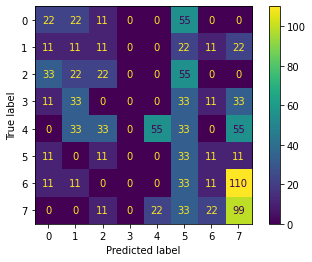

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(ytest_for_classifier, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

In [45]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']


In [46]:
print(classification_report(ytest_for_classifier, preds,labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33       110
           1       0.00      0.00      0.00         0

   micro avg       0.50      0.20      0.29       110
   macro avg       0.50      0.10      0.17       110
weighted avg       1.00      0.20      0.33       110



/Users/jacobo/opt/anaconda3/envs/bovine_embryo_survival_prediction/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobo/opt/anaconda3/envs/bovine_embryo_survival_prediction/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobo/opt/anaconda3/envs/bovine_embryo_survival_prediction/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t